In [5]:
#Python Default 

import pickle

#Essentials

import time
import numpy as np

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit
    
## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF

## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import *    #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP, COBYLA

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Primitives

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

from qiskit_ibm_runtime import Estimator as Estimator_Qiskit    #Estimator

%matplotlib widget


In [6]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

In [7]:
class VQEHistory:
    def __init__(self):
        self.counts = []
        self.values = []
        self.stds   = []

    def __call__(self, eval_count, parameters, mean, metadata):
        self.counts.append(eval_count)
        self.values.append(mean)
        self.stds.append( np.sqrt(metadata['variance']) )

    def clean(self):
        self.counts = []
        self.values = []
        self.stds   = []

    def add(self, val):
        self.values = np.array(self.values) + val

    def savetxt(self, file_name):
        np.savetxt(file_name, np.column_stack([self.counts, self.values, self.stds]))

def Estimator_intervalo(intervalo, base = "sto3g", optimizer = COBYLA(), backend = None, session = None, mapper = JordanWignerMapper(), shots = 2048, seed = 1):
    
    history = VQEHistory()
    
    for a in intervalo: 
        
        driver = PySCFDriver(
            atom= f"H 0 0 0; H 0 0 {a}",
            basis=base,
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
        )
        
        es_problem = driver.run()
        
        hamiltonian = es_problem.hamiltonian
        
        E_nuclear = hamiltonian.nuclear_repulsion_energy
        history.add(E_nuclear)
        history.savetxt('GroundState5/callback/%.4f_history.dat' % (a))
        history.clean()  

        estimator = Estimator_Qiskit(backend = backend, session = session, options = {'shots': shots})
        
        mapper = mapper
        
        ansatz = UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        )

        vqe_solver = VQE(estimator, ansatz, optimizer, callback=history)
        vqe_solver.initial_point = [0.0] * ansatz.num_parameters
        
        calc = GroundStateEigensolver(mapper, vqe_solver)
        
        res = calc.solve(es_problem)
        
        yield [a, res.groundenergy + res.nuclear_repulsion_energy]

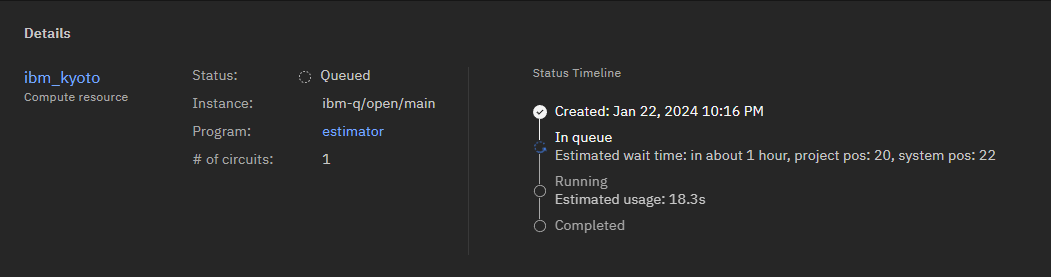

In [12]:
list(Estimator_intervalo([1], backend = backend, shots = 2048))

runtime_job._start_websocket_client:WARNING:2024-01-23 13:50:23,650: An error occurred while streaming results from the server for job cpqvbeddmm10008d3sc0:
Traceback (most recent call last):
  File "/home/gabriel/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/runtime_job.py", line 546, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/gabriel/.local/lib/python3.10/site-packages/qiskit_ibm_provider/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/gabriel/.local/lib/python3.10/site-packages/qiskit_ibm_provider/api/clients/base.py", line 230, in stream
    raise WebsocketError(error_message)
qiskit_ibm_provider.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/gabriel/.local/lib/python3.10/site-packages/websocket/_app.py", line 434, in setSock\n    dispatcher.

AlgorithmError: 'The primitive job to evaluate the energy failed!'

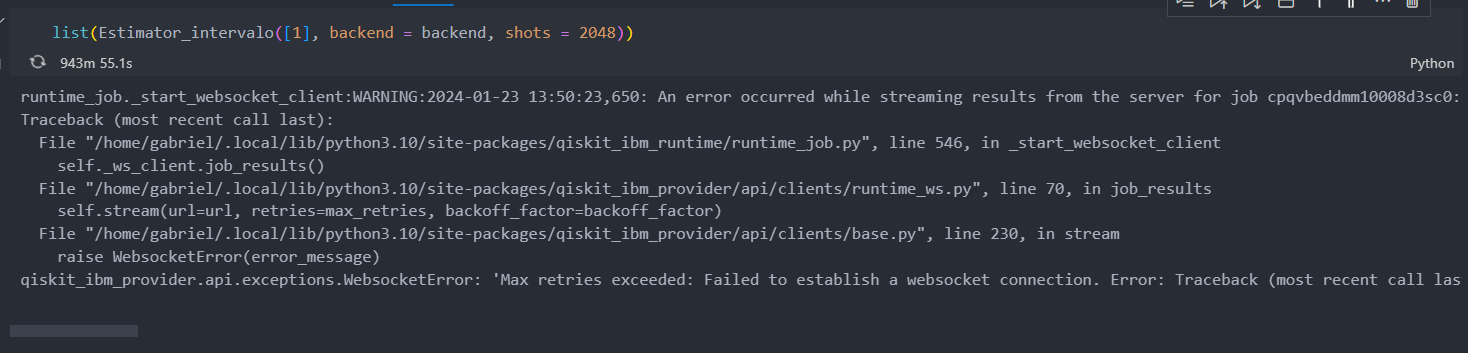

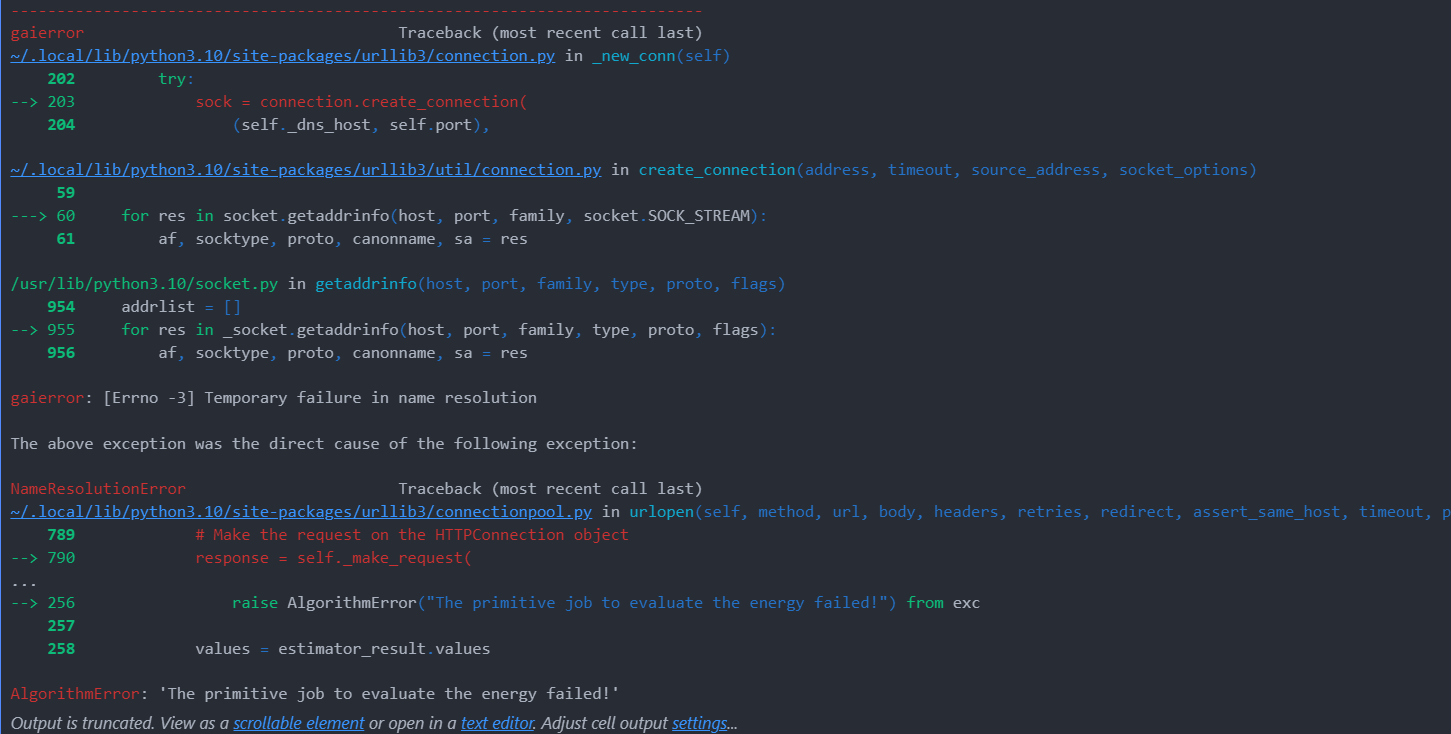